[next up](#here)

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from networkx.drawing.nx_pydot import pydot_layout

import pyphi.data_models as dm  # Prototype code
from pyphi.convert import sbs2sbn, sbn2sbs      

import pyphi
import numpy as np
from pprint import pprint

pyphi.config.PARTITION_TYPE = 'ALL'
pyphi.config.PICK_SMALLEST_PURVIEW = True
pyphi.config.VALIDATE_SUBSYSTEM_STATES = False

# Suppose that a prisoner dies either if A loads B’s gun and B shoots, or if C loads and shoots his gun.
# D = (A and B) or C
# Most intersting state: 101 -> 1. Here they don't want to say that A was a cause of D.

# Constants
# ============================================================================
#! NODES = 4
#! States = 2**NODES

#INI_STATE = (1, 0, 1, 1)
#cm0 = np.array([
#    [0, 0, 0, 1],
#    [0, 0, 0, 1],
#    [0, 0, 0, 1],
#    [0, 0, 0, 0]
#])

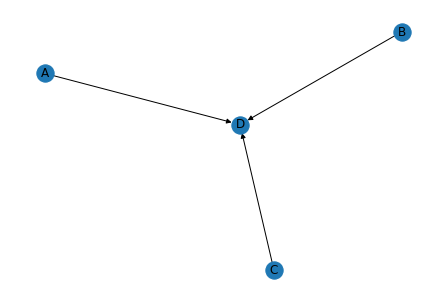

In [2]:
INI_STATE ='1010'
edges = [(0,3),(1,3),(2,3)]
net = dm.Net(edges=edges, SpN=2)
net.draw()
#print(f'Self-loops do not plot.  Actual edges = {[(i,j) for i,j in net.graph.edges()]}')

In [3]:
list(net.graph)

['A', 'B', 'C', 'D']

In [4]:
# Functions
# ============================================================================
def node_logic(*in_states):  # MODIFIED for v2 -sp-
    out_state = (in_states[0] and in_states[1]) or in_states[2]
    return out_state

net.get_node('D').func = node_logic
net.get_node('A').num_states = 3 # just to prove we can!
ps = INI_STATE #  Past State
cs = net.states.next_state(ps) # Current State
print(f'ps={ps} cs={cs}')

ps=1010 cs=1011


## TPM  
The mapping from the states of 3 input nodes (A,B,C) to the state of one output node (D) is done by a func of N args ("node_logic") attached to node D.

In [5]:
probs = np.array([[0.68893508, 0.40176953],
                      [0.44095309, 0.84035902],
                      [0.09975545, 0.58225631],
                      [0.86475645, 0.18650795],
                      [0.50721989, 0.86299773],
                      [0.62045787, 0.90525779],
                      [0.88270204, 0.46225991],
                      [0.51548114, 0.89159624]])
tpm = dm.TransProb(in_nodes=list('ABC'), out_nodes=list('D'), probabilities=probs)
#tpm.df.loc[:,:] = 9
tpm.df.loc['001',:] = [1,2]
tpm.df

,0,1
000,0.688935,0.401770
001,1.000000,2.000000
010,0.099755,0.582256
011,0.864756,0.186508
100,0.507220,0.862998
101,0.620458,0.905258
110,0.882702,0.462260
111,0.515481,0.891596


In [6]:
net.node_lut

{'A': 0, 'B': 1, 'C': 2, 'D': 3}

#### For All possible states, run mechanisms to get next state
Nodes default to noop mechanism. Node D set to node_logic. Three states for A.

In [7]:
[(s,net.states.next_state(s)) for s in net.states.gen_all_states()]

[('0000', '0000'),
 ('0001', '0000'),
 ('0010', '0011'),
 ('0011', '0011'),
 ('0100', '0100'),
 ('0101', '0100'),
 ('0110', '0111'),
 ('0111', '0111'),
 ('1000', '1000'),
 ('1001', '1000'),
 ('1010', '1011'),
 ('1011', '1011'),
 ('1100', '1101'),
 ('1101', '1101'),
 ('1110', '1111'),
 ('1111', '1111'),
 ('2000', '2000'),
 ('2001', '2000'),
 ('2010', '2011'),
 ('2011', '2011'),
 ('2100', '2101'),
 ('2101', '2101'),
 ('2110', '2111'),
 ('2111', '2111')]

In [8]:
list(tpm.df.columns)

['0', '1']

In [9]:
tpm.df.loc['001','1']

2.0

#### This function is not generalized enough!!!

In [10]:
states = dm.States(net)
dm.fill_using_mechanism(tpm,states)
tpm.df  # (A and B) or C

,0,1
000,1.0,0.0
001,0.0,1.0
010,1.0,0.0
011,0.0,1.0
100,1.0,0.0
101,0.0,1.0
110,0.0,1.0
111,0.0,1.0


# String rectangular TPMs appropriate for Feed-Forward net

About this graph:
Name: Feed-Forward
Type: DiGraph
Number of nodes: 12
Number of edges: 13
Average in degree:   1.0833
Average out degree:   1.0833


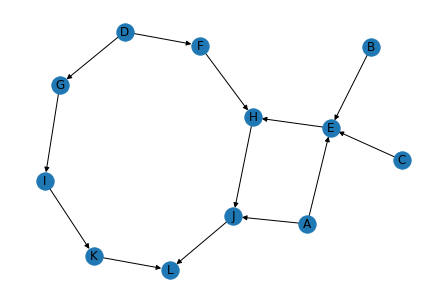

In [11]:
edges = [
    (0,4),        (0,9),
    (1,4), (4,7), (7,9),  (9,11),
    (2,4),
    (3,5), (5,7),
    (3,6), (6,8), (8,10), (10,11),
    ]
ff_net = dm.Net(edges=edges, title='Feed-Forward').draw()
print(f'About this graph:\n{nx.info(ff_net.graph)}')

In [19]:
print(f'Zaptc: {pyphi.zap_tc.Zaptc.__doc__}')

Zaptc: Change the state of a node or nodes and count state changes.

ZAPTC EXPERIMENT:

Zaptc ("zapticy") attempts to get useful counts of transitions to be
used to create a TPM.  It does this by walking the network
(initialized to a specific state) for a specified number of time
steps. It does this without knowing anything about how a node's state
is affected by its input (no knowledge of the node's mechanism). In
terms of cause-effect, it trades definitive state changes for what
MIGHT happen for a random and unknown mechanism. During the network
walk, the state of a downstream node may change iff one of its
upstream nodes changes state. Downstream state changes are stochastic.

The result of a full zaptc experiment is a table indexed by (in-state,
out-state) with a value of the number of times that state transition
was encountered in the walk. One walk is done for each of the nodes in
the system. At the start of the walk, a random system state is chosen
and the state of the selected 

In [13]:
ff_net.discover_tpm(verbose=True)

Gathering system state transition counts (time=10) ...
Zap node: A state: 1...11..1...
Zap node: B state: 111....111.1
Zap node: C state: .1111111.1.1
Zap node: D state: .111.11..1.1
Zap node: E state: .111.1....11
Zap node: F state: 1.11..1.1...
Zap node: G state: 1....11.1111
Zap node: H state: 1.111.1..11.
Zap node: I state: 1.....11.111
Zap node: J state: 1...1..1...1
Zap node: K state: 1.1.111.1...
Zap node: L state: ....1111111.
DONE


In [14]:
ff_net.ztc.transition_counter

Counter({('000011001000', '000011001000'): 1,
         ('000011001000', '000011011000'): 1,
         ('000011011000', '000011011000'): 3,
         ('000011001000', '000011001001'): 1,
         ('000011001001', '000011001001'): 1,
         ('101000011101', '101010011101'): 1,
         ('101010011101', '101010001101'): 1,
         ('101010001101', '101010001101'): 1,
         ('101010001101', '101010001100'): 1,
         ('101010001100', '101010001100'): 1,
         ('011111110101', '011101110101'): 1,
         ('011101110101', '011101100101'): 1,
         ('011101100101', '011101100101'): 3,
         ('011001100101', '011000000101'): 1,
         ('011000000101', '011000010101'): 1,
         ('011000010101', '011000010101'): 3,
         ('011000000101', '011000001101'): 1,
         ('011000001101', '011000001101'): 1,
         ('011000001101', '011000001100'): 1,
         ('011000001100', '011000001100'): 1,
         ('011101000011', '011101010011'): 1,
         ('011101010011', '0111010

In [15]:
ff_net.ztc.tpm_sbn

,0,1,2,3,4,5,6,7,8,9,10,11
100001100101,0.200000,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.000000,0.000000,0.200000,0.000000,0.200000
101011101010,0.142857,0.000000,0.142857,0.000000,0.142857,0.142857,0.142857,0.000000,0.142857,0.000000,0.142857,0.000000
000011011000,0.000000,0.000000,0.000000,0.000000,0.250000,0.250000,0.000000,0.250000,0.250000,0.000000,0.000000,0.000000
011101110101,0.000000,0.142857,0.142857,0.142857,0.000000,0.142857,0.142857,0.000000,0.000000,0.142857,0.000000,0.142857
101010001101,0.181818,0.000000,0.181818,0.000000,0.181818,0.000000,0.000000,0.000000,0.181818,0.181818,0.000000,0.090909
100001101111,0.166667,0.000000,0.000000,0.000000,0.000000,0.166667,0.166667,0.000000,0.000000,0.166667,0.166667,0.166667
000011001001,0.000000,0.000000,0.000000,0.000000,0.250000,0.250000,0.000000,0.000000,0.250000,0.000000,0.000000,0.250000
101010001100,0.200000,0.000000,0.200000,0.000000,0.200000,0.000000,0.000000,0.000000,0.200000,0.200000,0.000000,0.000000
011000001100,0.000000,0.250000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.250000,0.000000,0.000000
000011111111,0.000000,0.000000,0.000000,0.000000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000


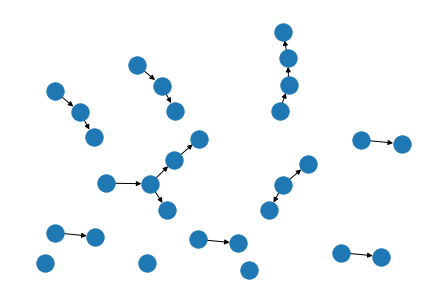

In [16]:
gg = ff_net.ztc.tpg()
nx.draw(gg, pos=pydot_layout(gg)) # How disjoint is this?

# Needs work beyond here !!! @@@ <a id=here>

In [17]:
#ps = tuple([int(e > 0.5) for e in state_evo[0]])
#cs = tuple([int(e > 0.5) for e in state_evo[1]])
transition = pyphi.Transition(net, ps, cs, (0,1,2), (3,))       

AttributeError: 'list' object has no attribute 'coerce_to_indices'

In [ ]:
account = pyphi.actual.account(transition)
print(account)

#import pdb; pdb.set_trace() 
print('---------------------------')

all_accounts = pyphi.actual.nexus(net, ps, cs)
all_accounts = sorted(all_accounts, key=lambda nexus: nexus.alpha, reverse=True)

pprint([(a.transition, a.alpha) for a in all_accounts])
# print(nexi[0])
# ac.context_print_mice(nexi[0].context)

In [ ]:
   for psi in range(States):
        ps = tuple(map(int, bin(psi)[2:].zfill(NODES)[::-1]))      
        tpm[psi, :] = node_logic(ps)

    state_evo = state_evolution(INI_STATE, 1)
    print(state_evo)
    print('---------------------------')
    
    print(f'tpm.shape={tpm.shape}')
    pd.DataFrame(tpm)
  

In [ ]:
cm = dm.CM()
cm.from_legacy(cm=cm0, labels=list('ABCD'))
cm.df

In [ ]:
    net = pyphi.Network(tpm, cm)

    ps = tuple([int(e > 0.5) for e in state_evo[0]])
    cs = tuple([int(e > 0.5) for e in state_evo[1]])

    transition = pyphi.Transition(net, ps, cs, (0,1,2), (3,))       
    
    account = pyphi.actual.account(transition)
    print(account)

    #import pdb; pdb.set_trace() 
    print('---------------------------')

    all_accounts = pyphi.actual.nexus(net, ps, cs)
    all_accounts = sorted(all_accounts, key=lambda nexus: nexus.alpha, reverse=True)

    pprint([(a.transition, a.alpha) for a in all_accounts])
    # print(nexi[0])
    # ac.context_print_mice(nexi[0].context)

    #! import pdb; pdb.set_trace() 

In [ ]:
len(cm0)

In [ ]:
cwd

In [ ]:
%cwd

In [ ]:
pwd